#**PHẦN II: PHÂN TÍCH THỊ TRƯỜNG TÀI CHÍNH BẰNG PCA**

#**Bước 1**

### 1.1 Thu thập danh sách cổ phiếu S&P 500 từ Wikipedia

**Mục tiêu chính:**
Lấy danh sách mã cổ phiếu (tickers) S&P 500 cập nhật từ Wikipedia làm đầu vào cho các bước sau. Wikipedia được chọn vì tính công khai, dễ truy cập và cập nhật tương đối tốt.

**Quy trình kỹ thuật:**

1.  **Gửi yêu cầu HTTP và tải nội dung HTML:**
    *   Gửi yêu cầu `GET` đến URL Wikipedia chứa danh sách S&P 500 bằng thư viện `requests`.
    *   **Thêm `User-Agent` Header:** Giả lập yêu cầu từ trình duyệt (ví dụ: Chrome) để tránh bị chặn bởi cơ chế chống bot/scraper của Wikipedia. Điều này giúp yêu cầu trông giống như từ người dùng thông thường.

2.  **Trích xuất dữ liệu bảng:**
    *   Sử dụng `pandas.read_html()` để tự động phân tích và trích xuất tất cả các bảng từ nội dung HTML.
    *   Chọn bảng đầu tiên (`tables[0]`), vì đây thường là bảng chứa danh sách cổ phiếu S&P 500.

3.  **Lấy danh sách mã Ticker:**
    *   Từ DataFrame thu được, trích xuất cột 'Symbol' để có danh sách các mã ticker.

4.  **Chuẩn hóa định dạng Ticker:**
    *   **Thao tác:** Thay thế dấu `.` bằng `-` trong mỗi ticker (ví dụ: `BRK.B` thành `BRK-B`).
    *   **Lý do:** Các nguồn dữ liệu khác nhau (Wikipedia vs. Yahoo Finance) có thể dùng định dạng ticker khác nhau. Chuẩn hóa giúp:
        *   **Đảm bảo tính tương thích:** Nhất quán với định dạng `yfinance` yêu cầu.
        *   **Tối đa hóa dữ liệu thu thập:** Giảm thiểu bỏ sót dữ liệu do khác biệt định dạng.
        *   Đây là bước tiền xử lý cần thiết để đảm bảo tính nhất quán khi làm việc với nhiều nguồn dữ liệu.

In [ ]:
import pandas as pd
import requests

# URL của trang Wikipedia chứa danh sách S&P 500
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Thêm header để giả lập trình duyệt, tránh bị chặn
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

# Gửi yêu cầu GET đến URL với header
response = requests.get(url, headers=headers)
response.raise_for_status()

In [ ]:
tables = pd.read_html(response.text)
sp500_table = tables[0]

sp500_tickers = sp500_table['Symbol'].tolist()

sp500_tickers = [ticker.replace('.', '-') for ticker in sp500_tickers]

print(f"Số lượng mã cổ phiếu S&P 500 tìm thấy: {len(sp500_tickers)}")
print("Một vài mã đầu tiên:", sp500_tickers[:10])

<ipython-input-2-010f258cc460>:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


Số lượng mã cổ phiếu S&P 500 tìm thấy: 503
Một vài mã đầu tiên: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


### 1.2 Dùng thư viện yfinance để lấy dữ liệu giá đóng cửa (Close) cho năm 2023

### 1.2 Dùng `yfinance` để lấy dữ liệu giá đóng cửa (Close) cho năm 2023

**Mục tiêu chính:**
Thu thập dữ liệu giá đóng cửa hàng ngày cho các cổ phiếu S&P 500 (từ 1.1) và chỉ số `^GSPC`. Dữ liệu này dùng để tính lợi suất và thực hiện PCA.

**Lựa chọn và lý do:**

1.  **Công cụ (`yfinance`):** Sử dụng `yfinance` để tải dữ liệu từ Yahoo Finance do tính tiện lợi, miễn phí và khả năng tải hàng loạt.
2.  **Loại dữ liệu (Giá đóng cửa - 'Close'):** Tải giá đóng cửa ('Close'), vì đây là mức giá tham chiếu phổ biến cho phân tích và đánh giá hiệu suất. Yahoo Finance cung cấp dữ liệu giá chi tiết, khác với Wikipedia.
3.  **Bao gồm `^GSPC`:** Thêm `^GSPC` để:
    *   Làm **benchmark** so sánh.
    *   **Đánh giá kết quả PCA** bằng cách so sánh với "chỉ số thị trường" tự tạo từ PC1.

**Quy trình kỹ thuật chính:**
*   **Đầu vào:** Xác định danh sách tickers (gồm `^GSPC`), khoảng thời gian và tần suất (hàng ngày - `'1d'`).
*   **Tải dữ liệu:** Sử dụng `yf.download()` để lấy giá đóng cửa.
*   **Xử lý lỗi:** Dùng `try-except` để quản lý lỗi (mạng, mã không hợp lệ) và thông báo các mã không tải được (`failed_tickers`) để đảm bảo minh bạch.

In [ ]:
import yfinance as yf
import datetime

tickers_to_download = sp500_tickers + ['^GSPC']

start_date = '2023-01-01'
end_date = '2024-01-01'

try:
    print(f"Bắt đầu tải dữ liệu cho {len(tickers_to_download)} mã từ {start_date} đến {end_date}...")
    price_data = yf.download(tickers_to_download, start=start_date, end=end_date, interval='1d')['Close']
    print("Tải dữ liệu hoàn tất.")
    failed_tickers = price_data.columns[price_data.isnull().all()].tolist()
    if failed_tickers:
        print(f"Cảnh báo: Các mã sau không có dữ liệu giá đóng cửa trong khoảng thời gian này: {failed_tickers}")

except Exception as e:
    print(f"Đã xảy ra lỗi trong quá trình tải dữ liệu: {e}")
    price_data = pd.DataFrame()

if not price_data.empty:
    print(f"\nKích thước DataFrame dữ liệu giá: {price_data.shape}") # (số ngày, số mã)
    print("\n5 dòng dữ liệu đầu tiên:")
    print(price_data.head())
    print("\n5 dòng dữ liệu cuối cùng:")
    print(price_data.tail())
else:
    print("\nKhông tải được dữ liệu giá.")

Bắt đầu tải dữ liệu cho 504 mã từ 2023-01-01 đến 2024-01-01...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  504 of 504 completed
ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['SOLV', 'GEV', 'SW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2023-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1672549200, endDate = 1704085200")')


Tải dữ liệu hoàn tất.
Cảnh báo: Các mã sau không có dữ liệu giá đóng cửa trong khoảng thời gian này: ['GEV', 'SOLV', 'SW']

Kích thước DataFrame dữ liệu giá: (250, 504)

5 dòng dữ liệu đầu tiên:
Ticker               A        AAPL        ABBV       ABNB         ABT  \
Date                                                                    
2023-01-03  147.617645  123.470612  147.798233  84.900002  104.295952   
2023-01-04  149.221313  124.744133  148.990616  88.720001  105.847321   
2023-01-05  149.654205  123.421265  148.808563  87.709999  105.457092   
2023-01-06  145.285873  127.962425  151.593765  88.519997  106.913322   
2023-01-09  145.089111  128.485657  147.142899  89.239998  106.742012   

Ticker           ACGL         ACN        ADBE         ADI        ADM  ...  \
Date                                                                  ...   
2023-01-03  59.393120  259.429962  336.920013  156.076004  82.784058  ...   
2023-01-04  59.687901  258.546753  341.410004  159.400269  79.

### 1.3 Tiền xử lý dữ liệu

#### a/ Tách riêng chỉ số SP500 (^GSPC)


*   **Thao tác:** Từ `price_data` ban đầu, tách dữ liệu giá của `^GSPC` ra thành `sp500_prices` và phần còn lại (giá các cổ phiếu thành phần) vào `stock_prices`.
*   **Lý do:**
    *   **Sử dụng riêng:** `^GSPC` dùng làm benchmark so sánh, không tham gia vào quá trình phân tích PCA cùng các cổ phiếu.
    *   **Phạm vi PCA:** PCA sẽ được thực hiện trên dữ liệu của các cổ phiếu thành phần (`stock_prices`) để tìm yếu tố biến động chung *giữa chúng*.

In [ ]:
import numpy as np
# --- 1. Tách riêng chỉ số S&P 500 (^GSPC) ---
if '^GSPC' in price_data.columns:
    sp500_prices = price_data[['^GSPC']].copy()
    stock_prices = price_data.drop(columns=['^GSPC'])
    print(f"Đã tách riêng chỉ số ^GSPC. Số lượng cổ phiếu còn lại: {stock_prices.shape[1]}")
else:
    print("Không tìm thấy cột ^GSPC trong dữ liệu.")
    stock_prices = price_data.copy()
    sp500_prices = pd.DataFrame()

Đã tách riêng chỉ số ^GSPC. Số lượng cổ phiếu còn lại: 503


#### b/ Xử lý thiếu dữ liệu (NaN) cho các cổ phiếu



*   **Vấn đề:** Dữ liệu giá có thể chứa NaN (do cổ phiếu không giao dịch, lỗi nguồn), gây lỗi cho PCA.
*   **Quy trình xử lý NaN (hai giai đoạn):**
    1.  **Loại bỏ cổ phiếu (cột) có tỷ lệ NaN cao:**
        *   **Thao tác:** Loại bỏ các cột (cổ phiếu) có tỷ lệ NaN vượt ngưỡng (ví dụ, 5%).
        *   **Lý do:** Cổ phiếu thiếu nhiều dữ liệu không đáng tin cậy, có thể làm sai lệch kết quả và giảm chất lượng dữ liệu chung.
    2.  **Loại bỏ ngày giao dịch (hàng) còn NaN:**
        *   **Thao tác:** Sau khi loại bỏ cột, dùng `dropna(axis=0, how='any')` để loại bỏ các hàng (ngày) còn chứa bất kỳ giá trị NaN nào.
        *   **Lý do:** Đảm bảo ma trận dữ liệu cuối cùng (`stock_prices_final`) "sạch", đầy đủ, không còn NaN, sẵn sàng cho các phép tính tiếp theo.

In [ ]:
# 2.1. Loại bỏ cổ phiếu có tỷ lệ NaN cao
total_days = len(stock_prices)
nan_percentage = stock_prices.isnull().sum() / total_days

# Xác định ngưỡng cho phép tỷ lệ NaN
nan_threshold = 0.05

# Lọc ra các mã cổ phiếu có tỷ lệ NaN VƯỢT QUÁ ngưỡng
tickers_to_drop = nan_percentage[nan_percentage > nan_threshold].index
if not tickers_to_drop.empty:
    stock_prices_cleaned = stock_prices.drop(columns=tickers_to_drop)
    print(f"\nĐã loại bỏ {len(tickers_to_drop)} cổ phiếu có > {nan_threshold*100:.1f}% dữ liệu thiếu.")
    print(f"Các mã bị loại bỏ: {tickers_to_drop.tolist()}")
    print(f"Số lượng cổ phiếu còn lại sau khi lọc cột: {stock_prices_cleaned.shape[1]}")
else:
    stock_prices_cleaned = stock_prices.copy()
    print(f"\nKhông có cổ phiếu nào bị loại bỏ do vượt ngưỡng NaN ({nan_threshold*100:.1f}%).")


Đã loại bỏ 5 cổ phiếu có > 5.0% dữ liệu thiếu.
Các mã bị loại bỏ: ['GEV', 'KVUE', 'SOLV', 'SW', 'VLTO']
Số lượng cổ phiếu còn lại sau khi lọc cột: 498


In [ ]:
# 2.2. Loại bỏ những ngày còn sót lại giá trị NaN (trong các cổ phiếu đã được lọc)
initial_rows = len(stock_prices_cleaned)
stock_prices_final = stock_prices_cleaned.dropna(axis=0, how='any')
rows_dropped = initial_rows - len(stock_prices_final)

if rows_dropped > 0:
    print(f"\nĐã loại bỏ {rows_dropped} ngày giao dịch có ít nhất một giá trị NaN ở các cổ phiếu còn lại.")
else:
    print("\nKhông có ngày giao dịch nào bị loại bỏ thêm.")

print(f"Kích thước DataFrame giá cổ phiếu cuối cùng (trước khi tính return): {stock_prices_final.shape}")


Không có ngày giao dịch nào bị loại bỏ thêm.
Kích thước DataFrame giá cổ phiếu cuối cùng (trước khi tính return): (250, 498)


#### c/ Tính tỉ suất sinh lợi hàng ngày (Daily Return)



*   **Mục tiêu:** Tính lợi suất hàng ngày (phần trăm thay đổi giá so với ngày hôm trước) từ giá cổ phiếu. Ngày đầu tiên sẽ có giá trị NaN (do không có ngày trước đó để so sánh) và sẽ được loại bỏ.
*   **Tại sao dùng lợi suất thay vì giá gốc cho PCA?**
    1.  **Loại bỏ xu hướng chung & đạt tính dừng (stationarity):**
        *   Giá gốc thường có xu hướng dài hạn (ví dụ: tăng do lạm phát), có thể tạo ra tương quan giả.
        *   Lợi suất tập trung vào thay đổi *hàng ngày*, loại bỏ ảnh hưởng của xu hướng dài hạn, giúp phân tích mối quan hệ thực sự giữa các cổ phiếu và thường làm cho chuỗi thời gian dừng hơn (điều kiện tốt cho nhiều mô hình thống kê).
    2.  **So sánh công bằng:**
        *   Thay đổi tuyệt đối về giá (ví dụ: tăng $1) có ý nghĩa khác nhau đối với cổ phiếu giá $10 và cổ phiếu giá $1000.
        *   Lợi suất (ví dụ: 10% vs. 0.1%) cho phép so sánh công bằng mức độ thay đổi tương đối giữa các cổ phiếu.
    3.  **Tập trung vào biến động ("rung lắc"):**
        *   PCA tìm kiếm các yếu tố gây ra sự biến động chung ("rung lắc") của cổ phiếu.
        *   Lợi suất là thước đo trực tiếp của sự "rung lắc" này.
    4.  **Tiêu chuẩn tài chính:** Lợi suất là "ngôn ngữ chung" khi thảo luận về hiệu suất và rủi ro trong tài chính.

In [ ]:
# Sử dụng DataFrame giá đã được làm sạch
daily_returns = stock_prices_final.pct_change()

# Dòng đầu tiên của daily_returns sẽ là NaN vì không có ngày trước đó để so sánh --> Chúng ta loại bỏ dòng này
daily_returns = daily_returns.dropna(axis=0, how='all')

print(f"\nĐã tính toán tỉ suất sinh lợi hàng ngày.")
print(f"Kích thước DataFrame daily_returns: {daily_returns.shape}")
print("\n5 dòng đầu tiên của daily_returns:")
print(daily_returns.head())
print("\n5 dòng cuối cùng của daily_returns:")
print(daily_returns.tail())


Đã tính toán tỉ suất sinh lợi hàng ngày.
Kích thước DataFrame daily_returns: (249, 498)

5 dòng đầu tiên của daily_returns:
Ticker             A      AAPL      ABBV      ABNB       ABT      ACGL  \
Date                                                                     
2023-01-04  0.010864  0.010314  0.008068  0.044994  0.014875  0.004963   
2023-01-05  0.002901 -0.010605 -0.001222 -0.011384 -0.003687  0.002708   
2023-01-06 -0.029190  0.036794  0.018717  0.009235  0.013809  0.015253   
2023-01-09 -0.001354  0.004089 -0.029360  0.008134 -0.001602 -0.019249   
2023-01-10  0.052621  0.004456 -0.012495 -0.007844  0.015158  0.006383   

Ticker           ACN      ADBE       ADI       ADM  ...       WTW        WY  \
Date                                                ...                       
2023-01-04 -0.003404  0.013327  0.021299 -0.036364  ...  0.005343  0.011990   
2023-01-05 -0.023613 -0.037990 -0.037490 -0.025003  ... -0.000203 -0.029779   
2023-01-06  0.023690  0.013123  0.036508

#### d/ Đồng bộ dữ liệu giá S&P 500 (`^GSPC`) với index của `daily_returns`



*   **Thao tác:** Căn chỉnh DataFrame `sp500_prices` (chứa giá `^GSPC`) theo index của `daily_returns` (đã được xử lý NaN và tính `pct_change`). Kết quả là `sp500_prices_aligned`.
*   **Tại sao:**
    *   **Nhất quán thời gian:** `daily_returns` có thể có số ngày ít hơn (ví dụ, mất ngày đầu tiên sau `pct_change()`) hoặc tập hợp ngày giao dịch khác so với `sp500_prices` ban đầu.
    *   **So sánh chính xác:** Đồng bộ index đảm bảo mọi so sánh giữa `^GSPC` và kết quả PCA (dựa trên `daily_returns`) được thực hiện trên cùng một tập hợp ngày giao dịch, giúp kết quả so sánh và tương quan chính xác, có ý nghĩa.

In [ ]:
#Chúng ta cần dữ liệu giá ^GSPC cho những ngày tương ứng với daily_returns để so sánh sau này
if not sp500_prices.empty:
    sp500_prices_aligned = sp500_prices.loc[daily_returns.index]
    print(f"\nĐã đồng bộ index của ^GSPC với daily_returns.")
    print(f"Kích thước sp500_prices_aligned: {sp500_prices_aligned.shape}")

    if sp500_prices_aligned.isnull().values.any():
        print("Cảnh báo: Có giá trị NaN trong dữ liệu giá ^GSPC sau khi đồng bộ hóa. Cần xử lý thêm nếu cần.")
else:
    sp500_prices_aligned = pd.DataFrame()


Đã đồng bộ index của ^GSPC với daily_returns.
Kích thước sp500_prices_aligned: (249, 1)


#**Bước 2**
**Mục tiêu bao trùm của Bước 2:**
Từ dữ liệu lợi suất hàng ngày của các cổ phiếu, tìm ra Thành phần Chính thứ nhất (PC1) – "đặc điểm" hoặc "xu hướng biến động" chung nhất, quan trọng nhất, đại diện cho "sức khỏe" hoặc "hướng đi chung" của thị trường.

---


### 2.1 Chuẩn hóa dữ liệu return theo từng cổ phiếu để có trung bình bằng 0


*   **Dữ liệu đầu vào:** Lợi suất hàng ngày của mỗi cổ phiếu (từ Bước 1.3c).
*   **Thực hiện:** Với mỗi cổ phiếu, trừ lợi suất trung bình hàng ngày của nó khỏi mỗi giá trị lợi suất hàng ngày. Kết quả là lợi suất mới có trung bình bằng 0 (centering).
*   **Tại sao Centering?**
    1.  **Tập trung vào "rung lắc đồng bộ":** Giúp PCA phân tích cách các cổ phiếu biến động *cùng nhau* (covariance) thay vì bị ảnh hưởng bởi mức lợi suất trung bình khác nhau ("ai thường lời/lỗ hơn"). Điều này đảm bảo PC1 phản ánh mô hình biến động chung thực sự.
    2.  **Đơn giản hóa toán học PCA:** Đảm bảo ma trận hiệp phương sai phản ánh sự biến động quanh điểm gốc (trung bình 0).

In [ ]:
import numpy as np

# Tính trung bình lợi suất hàng ngày cho mỗi cổ phiếu (axis=0)
mean_returns = daily_returns.mean(axis=0)

# Trừ trung bình khỏi mỗi cột để chuẩn hóa
returns_standardized = daily_returns - mean_returns

print("Đã chuẩn hóa dữ liệu daily_returns (trừ trung bình).")
print(f"Kích thước DataFrame returns_standardized: {returns_standardized.shape}")

# Kiểm tra lại trung bình của một vài cột (nên rất gần 0)
print("\nKiểm tra trung bình của 5 cột đầu tiên sau chuẩn hóa:")
print(returns_standardized.iloc[:, :5].mean(axis=0))

print("\n5 dòng đầu tiên của returns_standardized:")
print(returns_standardized.head())

Đã chuẩn hóa dữ liệu daily_returns (trừ trung bình).
Kích thước DataFrame returns_standardized: (249, 498)

Kiểm tra trung bình của 5 cột đầu tiên sau chuẩn hóa:
Ticker
A       1.330651e-18
AAPL   -3.633166e-18
ABBV   -2.336477e-18
ABNB   -1.769557e-18
ABT     1.894959e-18
dtype: float64

5 dòng đầu tiên của returns_standardized:
Ticker             A      AAPL      ABBV      ABNB       ABT      ACGL  \
Date                                                                     
2023-01-04  0.010999  0.008479  0.008019  0.042742  0.014700  0.004137   
2023-01-05  0.003036 -0.012440 -0.001270 -0.013637 -0.003862  0.001882   
2023-01-06 -0.029054  0.034959  0.018668  0.006983  0.013634  0.014427   
2023-01-09 -0.001219  0.002254 -0.029409  0.005881 -0.001777 -0.020075   
2023-01-10  0.052756  0.002621 -0.012544 -0.010096  0.014983  0.005557   

Ticker           ACN      ADBE       ADI       ADM  ...       WTW        WY  \
Date                                                ...               

### 2.2 Tính ma trận hiệp phương sai (covariance matrix) của các return


*   **Thực hiện:**
    1.  Từ lợi suất đã chuẩn hóa (trung bình bằng 0), tính ma trận hiệp phương sai.
        *   **Lưu ý `numpy.cov`:** Sử dụng `np.cov(returns_standardized, rowvar=False)` vì trong DataFrame, mỗi **cột** là một biến (cổ phiếu).
    2.  **Ý nghĩa ma trận:**
        *   Mỗi ô thể hiện mức độ "rung lắc" (thay đổi giá) *cùng nhau* của một cặp cổ phiếu (dương: cùng chiều, âm: ngược chiều, gần 0: ít liên quan).
        *   Đường chéo chính là *phương sai* (mức độ "rung lắc" riêng) của từng cổ phiếu.
*   **Tại sao tính ma trận này?**
    1.  **Hiểu sự đồng điệu thị trường:** Cung cấp "bản đồ" chi tiết về các mối quan hệ biến động giữa các cặp cổ phiếu.
    2.  **Đầu vào chính cho PCA:** PCA sẽ phân tích ma trận này để tìm ra các "kiểu rung lắc đồng bộ" chính (Thành phần Chính).

In [ ]:
if returns_standardized.isnull().values.any():
    print("Cảnh báo: Vẫn còn giá trị NaN trong dữ liệu lợi suất chuẩn hóa!")

else:
    cov_matrix = np.cov(returns_standardized, rowvar=False)

    print(f"\nĐã tính ma trận hiệp phương sai.")
    print(f"Kích thước ma trận hiệp phương sai: {cov_matrix.shape}")
    print("\nGóc trên bên trái (5x5) của ma trận hiệp phương sai:")
    print(pd.DataFrame(cov_matrix, index=returns_standardized.columns, columns=returns_standardized.columns).iloc[:5, :5])


Đã tính ma trận hiệp phương sai.
Kích thước ma trận hiệp phương sai: (498, 498)

Góc trên bên trái (5x5) của ma trận hiệp phương sai:
Ticker         A          AAPL          ABBV      ABNB       ABT
Ticker                                                          
A       0.000286  4.110187e-05  2.002097e-05  0.000108  0.000082
AAPL    0.000041  1.580060e-04 -5.115834e-07  0.000124  0.000036
ABBV    0.000020 -5.115834e-07  1.526832e-04 -0.000008  0.000036
ABNB    0.000108  1.242855e-04 -8.325384e-06  0.000717  0.000053
ABT     0.000082  3.560800e-05  3.636494e-05  0.000053  0.000157


### 2.3 Tính trị riêng (eigenvalues) và vector riêng (eigenvectors)

*   **Thực hiện:**
    1.  Áp dụng **phân rã trị riêng (eigendecomposition)** lên ma trận hiệp phương sai (đối xứng).
        *   **Công cụ:** `numpy.linalg.eigh` (tối ưu cho ma trận đối xứng, đảm bảo trị riêng thực, vector riêng trực giao).
    2.  **Kết quả:**
        *   **Vector riêng (Eigenvectors):** Mô tả "kiểu/hướng rung lắc đồng bộ" cụ thể. Chúng trực giao (độc lập).
        *   **Trị riêng (Eigenvalues):** Đo lường "sức mạnh" (lượng phương sai giải thích được) của mỗi "kiểu rung lắc" tương ứng.
*   **Tại sao thực hiện phân rã này?**
    1.  **"Bóc tách" nguồn biến động:** Phân rã sự phức tạp của ma trận hiệp phương sai thành các "mảnh ghép" (vector riêng) và "sức mạnh" (trị riêng) đơn giản hơn.
    2.  **Xác định Thành phần Chính (PCs):** Mỗi cặp (vector riêng, trị riêng) là một PC. Vector riêng định nghĩa *hướng*, trị riêng cho biết *lượng phương sai* PC đó giải thích. Mục tiêu là tìm PC có trị riêng lớn nhất.

In [ ]:
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

print("\nĐã tính trị riêng và vector riêng.")
print(f"Số lượng trị riêng tìm thấy: {len(eigenvalues)}")
print(f"Kích thước ma trận vector riêng: {eigenvectors.shape}")

print("\n5 trị riêng đầu tiên (chưa sắp xếp):")
print(eigenvalues[:5])
print("\nMột phần vector riêng đầu tiên (chưa sắp xếp) - 5 giá trị đầu:")
print(eigenvectors[:5, 0])


Đã tính trị riêng và vector riêng.
Số lượng trị riêng tìm thấy: 498
Kích thước ma trận vector riêng: (498, 498)

5 trị riêng đầu tiên (chưa sắp xếp):
[-2.59903202e-18 -2.11713363e-18 -1.95033736e-18 -1.92053168e-18
 -1.79763862e-18]

Một phần vector riêng đầu tiên (chưa sắp xếp) - 5 giá trị đầu:
[ 0.         -0.37436866 -0.43965352  0.04723919  0.04067205]


### 2.4 Sắp xếp các thành phần chính theo thứ tự giảm dần của trị riêng

*   **Thực hiện:** Sắp xếp các cặp (vector riêng, trị riêng) thu được ở bước 2.3 theo thứ tự trị riêng giảm dần.
*   **Tại sao?**
    1.  **Xác định PC quan trọng nhất:** PC có trị riêng lớn nhất (PC1) giải thích nhiều phương sai nhất và thường đại diện cho yếu tố thị trường chung.
    2.  **PC1 thường là yếu tố thị trường:** Trong phân tích chứng khoán, PC1 nắm bắt xu hướng biến động chung mà hầu hết cổ phiếu cùng chia sẻ.

In [ ]:
# Lấy chỉ số để sắp xếp eigenvalues theo thứ tự giảm dần
sorted_indices = np.argsort(eigenvalues)[::-1] # [::-1] để đảo ngược thành giảm dần

# Sắp xếp lại eigenvalues và eigenvectors dựa trên chỉ số đã lấy
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

print("\nĐã sắp xếp trị riêng và vector riêng theo thứ tự giảm dần của trị riêng.")

print("\n5 trị riêng hàng đầu (đã sắp xếp):")
print(sorted_eigenvalues[:5])

# Vector riêng ứng với trị riêng lớn nhất (PC1) là cột đầu tiên của sorted_eigenvectors
pc1_eigenvector = sorted_eigenvectors[:, 0]

print("\nVector riêng thứ nhất (PC1) - 10 giá trị đầu:")
print(pc1_eigenvector[:10])


Đã sắp xếp trị riêng và vector riêng theo thứ tự giảm dần của trị riêng.

5 trị riêng hàng đầu (đã sắp xếp):
[0.0470821  0.00948972 0.00675891 0.00511587 0.0034078 ]

Vector riêng thứ nhất (PC1) - 10 giá trị đầu:
[-0.0400096  -0.03112084 -0.00688137 -0.07122449 -0.02066675 -0.01736768
 -0.03922188 -0.04786887 -0.05098177 -0.03201013]


### 2.5 Dựng thành phần chính đầu tiên (PC1) và biểu diễn PC1 theo thời gian

*   **Thực hiện:**
    1.  **Xác định Vector Trọng số PC1 (`pc1_weights`):**
        *   Lấy vector riêng ứng với trị riêng lớn nhất (từ 2.4). Vector này chứa trọng số (loadings) của mỗi cổ phiếu đối với PC1.
        *   Chuyển thành `pandas.Series` với index là tên mã cổ phiếu (từ `returns_standardized.columns`) để dễ đọc, hiểu và tự động căn chỉnh khi tính toán.
    2.  **Tính Điểm số PC1 hàng ngày (`pc1_scores`):**
        *   Nhân ma trận `returns_standardized` (lợi suất đã chuẩn hóa) với `pc1_weights` (dùng `dot product`).
        *   Kết quả (`pc1_scores`): Là chuỗi thời gian "lợi suất tổng hợp hàng ngày" của yếu tố thị trường mà PC1 nắm bắt.
    3.  **Trực quan hóa `pc1_scores`:** Vẽ đồ thị `pc1_scores` theo thời gian để xem diễn biến của "lợi suất thị trường theo PC1".

*   **Tại sao thực hiện các bước này?**
    1.  **Xây dựng Thước đo Lợi suất cho Yếu tố Thị trường PC1:** `pc1_scores` thể hiện lợi suất hàng ngày của yếu tố thị trường chung mà PC1 "khám phá" được.
    2.  **Chuẩn bị So sánh và Đánh giá (Bước 3):** `pc1_scores` (hoặc chỉ số giá từ nó) sẽ được dùng để so sánh với S&P 500, đánh giá khả năng PCA nắm bắt động lực thị trường.

In [ ]:
# returns_standardized.columns chứa tên các mã cổ phiếu theo đúng thứ tự
pc1_weights = pd.Series(pc1_eigenvector, index=returns_standardized.columns)

print("\nĐã tạo Series trọng số cho Thành phần chính thứ nhất (PC1).")
print(f"Số lượng trọng số (cổ phiếu): {len(pc1_weights)}")

print("\n10 trọng số PC1 đầu tiên (theo thứ tự cổ phiếu trong DataFrame):")
print(pc1_weights.head(10))

print("\n10 trọng số PC1 cuối cùng:")
print(pc1_weights.tail(10))

# Kiểm tra xem tổng bình phương các trọng số có bằng 1 không (tính chất của vector riêng chuẩn hóa)
print(f"\nTổng bình phương các trọng số PC1 (nên gần bằng 1): {np.sum(pc1_weights**2):.4f}")


Đã tạo Series trọng số cho Thành phần chính thứ nhất (PC1).
Số lượng trọng số (cổ phiếu): 498

10 trọng số PC1 đầu tiên (theo thứ tự cổ phiếu trong DataFrame):
Ticker
A      -0.040010
AAPL   -0.031121
ABBV   -0.006881
ABNB   -0.071224
ABT    -0.020667
ACGL   -0.017368
ACN    -0.039222
ADBE   -0.047869
ADI    -0.050982
ADM    -0.032010
dtype: float64

10 trọng số PC1 cuối cùng:
Ticker
WTW    -0.021365
WY     -0.051410
WYNN   -0.049769
XEL    -0.018565
XOM    -0.027220
XYL    -0.040253
YUM    -0.021017
ZBH    -0.023858
ZBRA   -0.077476
ZTS    -0.037989
dtype: float64

Tổng bình phương các trọng số PC1 (nên gần bằng 1): 1.0000



--- Tính toán PC1 Scores (Chuẩn PCA) ---
5 giá trị PC1 Scores đầu tiên:
Date
2023-01-04   -0.376891
2023-01-05    0.283472
2023-01-06   -0.500983
2023-01-09   -0.074289
2023-01-10   -0.179074
dtype: float64


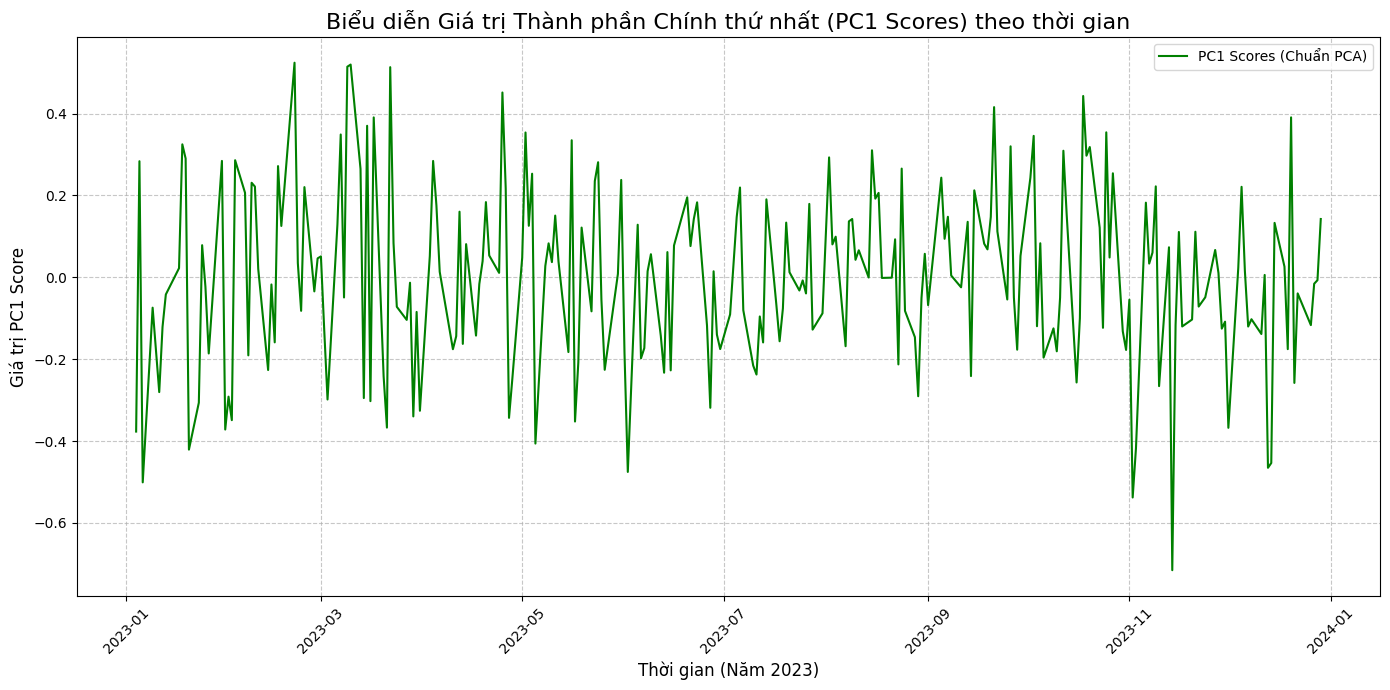

In [ ]:
import matplotlib.pyplot as plt

# Tính và vẽ PC1 Scores theo thời gian (theo chuẩn PCA)
pc1_scores = returns_standardized.dot(pc1_weights)

print("\n--- Tính toán PC1 Scores (Chuẩn PCA) ---")
print("5 giá trị PC1 Scores đầu tiên:")
print(pc1_scores.head())

# Vẽ đồ thị PC1 Scores
plt.figure(figsize=(14, 7))
plt.plot(pc1_scores.index, pc1_scores, label='PC1 Scores (Chuẩn PCA)', color='green')
plt.title('Biểu diễn Giá trị Thành phần Chính thứ nhất (PC1 Scores) theo thời gian', fontsize=16)
plt.xlabel('Thời gian (Năm 2023)', fontsize=12)
plt.ylabel('Giá trị PC1 Score', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#**Bước 3**

**Mục tiêu bao trùm của Bước 3:**
Từ "lợi suất hàng ngày" của PC1 (`pc1_scores` - Bước 2), xây dựng "chỉ số giá PC1" (`PC1_index`), sau đó trực quan hóa, so sánh và định lượng mối quan hệ của nó với chỉ số S&P 500 thực tế để đánh giá khả năng PCA nắm bắt yếu tố thị trường.

---

### 3.1 Tạo biến mới (PC1_index) bằng cách nhân giá với trọng số từ PC1, vẽ đồ thị PC1_index theo thời gian

*   **Mục tiêu:** Chuyển đổi `pc1_scores` (lợi suất PC1) sang dạng "chỉ số giá" (`PC1_index`) để so sánh trực quan với S&P 500 (vốn là chỉ số giá).
*   **Nền tảng từ Bước 2:**
    *   `pc1_weights`: Trọng số của mỗi cổ phiếu đối với PC1.
    *   `pc1_scores`: Lợi suất hàng ngày của yếu tố PC1.
*   **Tại sao cần `PC1_index`?**
    1.  **So sánh tương đồng:** S&P 500 là chỉ số giá, `pc1_scores` là lợi suất. Cần tạo `PC1_index` (dạng giá) để so sánh "táo với táo".
    2.  **Xây dựng "Giá trị Danh mục PC1":** `PC1_index` được tính bằng `stock_prices_final.dot(pc1_weights)`, thể hiện "giá trị" của một "danh mục PC1" thay đổi theo thời gian.
*   **Quy trình kỹ thuật:**
    1.  **Tính `PC1_index`:** Nhân ma trận `stock_prices_final` (giá cổ phiếu đã làm sạch) với `pc1_weights`. Đảm bảo căn chỉnh cột/index trước khi nhân.
    2.  Chuyển `PC1_index` thành DataFrame một cột (`pc1_index_df`) và kiểm tra sơ bộ.
    3.  Vẽ đồ thị `PC1_index` theo thời gian.

In [ ]:
# Kiểm tra sự khớp nhau giữa cột giá và index trọng số (khớp nếu làm đúng)
if not stock_prices_final.columns.equals(pc1_weights.index):
    print("CẢNH BÁO: Cột của DataFrame giá và index của Series trọng số không khớp!")
    print("Đang thử căn chỉnh lại...")
    stock_prices_final_aligned, pc1_weights_aligned = stock_prices_final.align(pc1_weights, join='inner', axis=1)
    if stock_prices_final_aligned.shape[1] != len(pc1_weights):
         print(f"Lỗi nghiêm trọng: Số cột sau căn chỉnh ({stock_prices_final_aligned.shape[1]}) không bằng số trọng số ban đầu ({len(pc1_weights)}). Kiểm tra lại các bước trước.")

    else:
         print("Căn chỉnh thành công.")
         pc1_index = stock_prices_final_aligned.dot(pc1_weights_aligned)

else:
    print("Cột của DataFrame giá và index của Series trọng số đã khớp.")
    pc1_index = stock_prices_final.dot(pc1_weights)

print("\nĐã tính toán PC1_index.")

pc1_index_df = pc1_index.to_frame(name='PC1_Index')
print("\nThông tin về PC1_index:")
pc1_index_df.info()

print("\n5 giá trị đầu của PC1_index:")
print(pc1_index_df.head())
print("\n5 giá trị cuối của PC1_index:")
print(pc1_index_df.tail())

Cột của DataFrame giá và index của Series trọng số đã khớp.

Đã tính toán PC1_index.

Thông tin về PC1_index:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2023-01-03 to 2023-12-29
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PC1_Index  250 non-null    float64
dtypes: float64(1)
memory usage: 12.0 KB

5 giá trị đầu của PC1_index:
              PC1_Index
Date                   
2023-01-03 -2845.630226
2023-01-04 -2890.850912
2023-01-05 -2850.013602
2023-01-06 -2917.775203
2023-01-09 -2926.402165

5 giá trị cuối của PC1_index:
              PC1_Index
Date                   
2023-12-22 -3573.668624
2023-12-26 -3594.885522
2023-12-27 -3602.929643
2023-12-28 -3603.353182
2023-12-29 -3589.543595


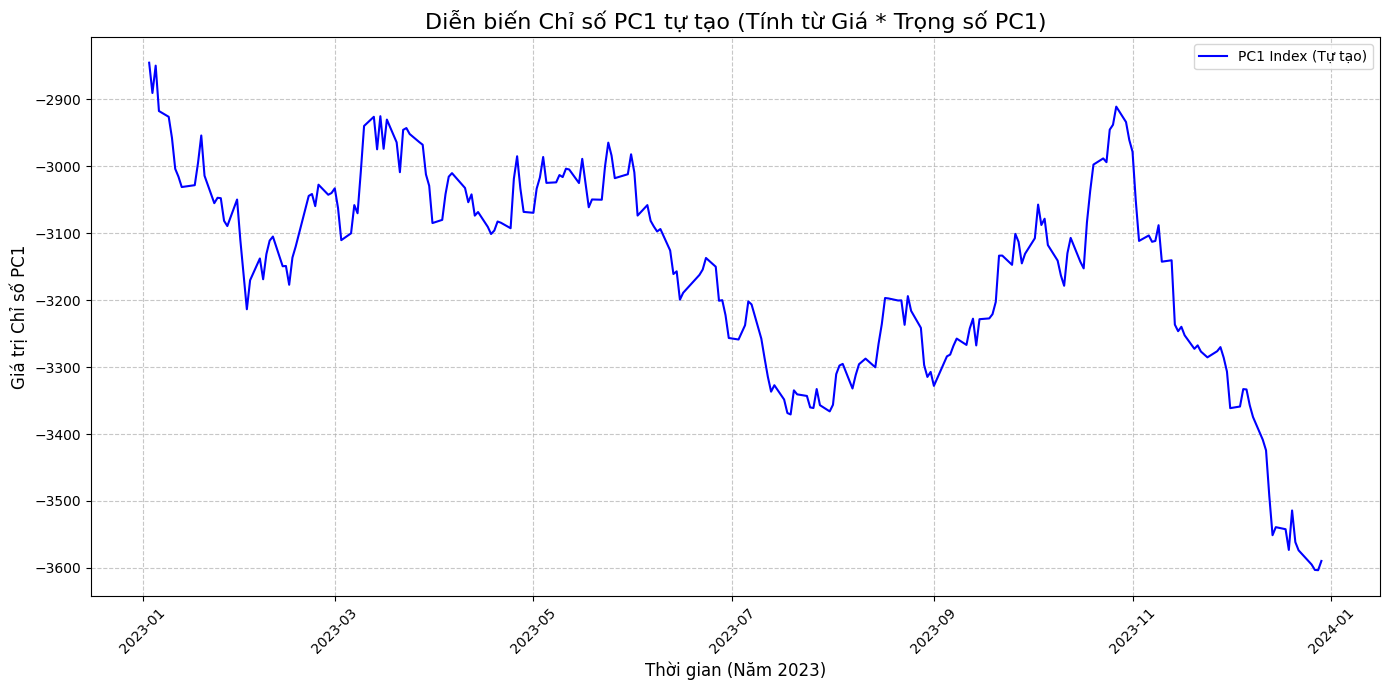

In [ ]:
# --- Vẽ đồ thị PC1_index theo thời gian ---
try:
    plt.figure(figsize=(14, 7))
    plt.plot(pc1_index_df.index, pc1_index_df['PC1_Index'], label='PC1 Index (Tự tạo)', color='blue')
    plt.title('Diễn biến Chỉ số PC1 tự tạo (Tính từ Giá * Trọng số PC1)', fontsize=16)
    plt.xlabel('Thời gian (Năm 2023)', fontsize=12)
    plt.ylabel('Giá trị Chỉ số PC1', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"\nĐã xảy ra lỗi khi vẽ đồ thị: {e}")
    print("Vui lòng kiểm tra dữ liệu 'pc1_index_df'.")

### 3.2 Vẽ thêm đường biểu diễn chỉ số S&P 500 thực tế (^GSPC) vào cùng đồ thị để so sánh


*   **Mục tiêu:** So sánh trực quan xu hướng biến động của `PC1_index` với `^GSPC` để đánh giá khả năng PCA nắm bắt động lực thị trường.
*   **Vấn đề:** `PC1_index` và `^GSPC` có thang đo và dấu khác nhau, khó so sánh trực tiếp.
*   **Giải pháp: Chuẩn hóa (Normalization)**
    1.  **Đưa về cùng điểm xuất phát (100):** Với cả `PC1_index` và `^GSPC`, lấy giá trị ngày đầu làm gốc, chia tất cả giá trị sau đó cho giá trị gốc rồi nhân 100. (Lưu ý: Nếu `PC1_index` âm, chuẩn hóa sẽ làm nó dương).
    2.  **Dữ liệu:** `pc1_index_df` và `sp500_prices_aligned` (đã căn chỉnh index).
*   **Quy trình kỹ thuật:**
    1.  Lấy giá trị khởi đầu (`iloc[0]`) của cả hai chuỗi.
    2.  Thực hiện chuẩn hóa để cả hai bắt đầu từ 100.
    3.  Vẽ đồ thị hai chuỗi đã chuẩn hóa trên cùng một biểu đồ để so sánh hình dạng và xu hướng.

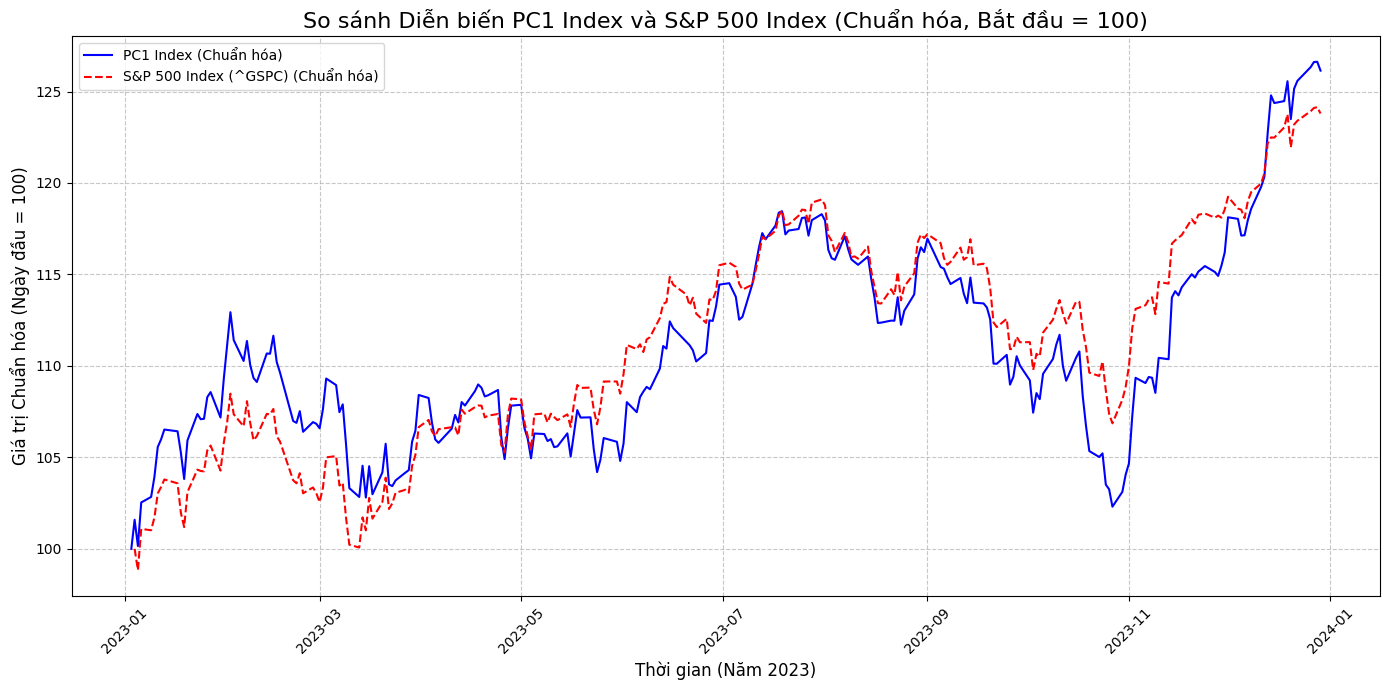


Đã vẽ đồ thị so sánh PC1 Index và S&P 500 Index (đã chuẩn hóa).

5 giá trị chuẩn hóa đầu tiên của PC1:
Date
2023-01-03    100.000000
2023-01-04    101.589127
2023-01-05    100.154039
2023-01-06    102.535290
2023-01-09    102.838455
Name: PC1_Index, dtype: float64

5 giá trị chuẩn hóa đầu tiên của S&P 500:
Date
2023-01-04    100.000000
2023-01-05     98.835447
2023-01-06    101.092926
2023-01-09    101.015324
2023-01-10    101.720232
Name: ^GSPC, dtype: float64


In [ ]:
# pc1_index_df: DataFrame chứa cột 'PC1_Index' (kết quả từ bước 3.1)
# sp500_prices_aligned: DataFrame chứa cột '^GSPC', đã được căn chỉnh index (từ bước 1.3)


# Kiểm tra sự tồn tại và không rỗng của sp500_prices_aligned
if 'sp500_prices_aligned' not in locals() or sp500_prices_aligned.empty:
    print("Lỗi: Không tìm thấy biến 'sp500_prices_aligned' hoặc biến này rỗng.")
    print("Vui lòng chạy lại Bước 1.3 để đảm bảo dữ liệu ^GSPC được xử lý đúng.")
else:
    # --- Chuẩn hóa cả hai chỉ số về điểm xuất phát 100 ---
    pc1_start_value = pc1_index_df['PC1_Index'].iloc[0]
    sp500_start_value = sp500_prices_aligned['^GSPC'].iloc[0]

    # Chuẩn hóa (normalize)
    # Đối với pc1_index (đang âm), việc chia cho giá trị âm đầu tiên sẽ làm nó thành dương.
    # Điều này giúp so sánh hình dạng đường đi dễ hơn.
    pc1_index_normalized = (pc1_index_df['PC1_Index'] / pc1_start_value) * 100
    sp500_normalized = (sp500_prices_aligned['^GSPC'] / sp500_start_value) * 100

    # --- Vẽ đồ thị so sánh ---
    plt.figure(figsize=(14, 7))

    # Vẽ PC1 Index chuẩn hóa
    plt.plot(pc1_index_normalized.index, pc1_index_normalized, label='PC1 Index (Chuẩn hóa)', color='blue')

    # Vẽ S&P 500 Index chuẩn hóa
    plt.plot(sp500_normalized.index, sp500_normalized, label='S&P 500 Index (^GSPC) (Chuẩn hóa)', color='red', linestyle='--')

    plt.title('So sánh Diễn biến PC1 Index và S&P 500 Index (Chuẩn hóa, Bắt đầu = 100)', fontsize=16)
    plt.xlabel('Thời gian (Năm 2023)', fontsize=12)
    plt.ylabel('Giá trị Chuẩn hóa (Ngày đầu = 100)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("\nĐã vẽ đồ thị so sánh PC1 Index và S&P 500 Index (đã chuẩn hóa).")
    print("\n5 giá trị chuẩn hóa đầu tiên của PC1:")
    print(pc1_index_normalized.head())
    print("\n5 giá trị chuẩn hóa đầu tiên của S&P 500:")
    print(sp500_normalized.head())

### 3.3 Tính hệ số tương quan giữa PC1_index và S&P 500

*   **Mục tiêu:** Định lượng mối quan hệ tuyến tính giữa `PC1_index` (tự tạo) và `^GSPC` (thực tế) sau khi đã so sánh trực quan.
*   **Công cụ:** Hệ số tương quan Pearson (giá trị từ -1 đến +1).
*   **Vấn đề cần xử lý: Đồng bộ Index**
    *   **Nguyên nhân & Hậu quả:** `pc1_index_df` (từ `stock_prices_final`) có thể nhiều hơn `sp500_prices_aligned` (từ `daily_returns` đã mất ngày đầu) một ngày. Tính tương quan trên chuỗi không khớp index sẽ sai.
    *   **Giải pháp:** Căn chỉnh index của `PC1_index` (gốc và chuẩn hóa) theo index của `sp500_prices_aligned` (hoặc `daily_returns`).
*   **Quy trình kỹ thuật:**
    1.  **Căn chỉnh Index:** Lấy `target_index` từ `sp500_prices_aligned.index`. Lọc các phiên bản của `PC1_index` (gốc và chuẩn hóa) theo `target_index` này.
    2.  **Tính Tương quan:**
        *   Giữa `PC1_index` gốc (đã căn chỉnh) và `^GSPC` (đã căn chỉnh). Kỳ vọng có thể âm và gần -1 nếu `pc1_weights` chủ yếu âm.
        *   Giữa `PC1_index` chuẩn hóa (đã căn chỉnh) và `^GSPC` chuẩn hóa (đã căn chỉnh). Kỳ vọng dương và gần +1.
*   **Ý nghĩa kết quả:** Giá trị tương quan gần +/-1 khẳng định mối liên hệ tuyến tính chặt chẽ, củng cố kết luận từ đồ thị.

In [ ]:
# pc1_index_df: DataFrame chứa cột 'PC1_Index' (index gốc từ stock_prices_final)
# sp500_prices_aligned: DataFrame chứa cột '^GSPC' (index đã align với daily_returns)
# daily_returns: DataFrame lợi suất (để lấy index chuẩn)
# pc1_index_normalized: Series PC1 chuẩn hóa (tính từ pc1_index_df gốc)
# sp500_normalized: Series S&P500 chuẩn hóa (tính từ sp500_prices_aligned)
# --------------------------------------------------------

print("--- Căn chỉnh Index trước khi tính Tương quan ---")

# Lấy index chuẩn từ daily_returns (hoặc sp500_prices_aligned vì chúng giống nhau)
target_index = sp500_prices_aligned.index

# Căn chỉnh pc1_index_df để khớp với target_index
pc1_index_df_aligned = pc1_index_df.loc[target_index]

# Lấy Series gốc từ các DataFrame đã căn chỉnh index
pc1_series_original_aligned = pc1_index_df_aligned['PC1_Index']
sp500_series_original = sp500_prices_aligned['^GSPC']

# Kiểm tra lại sự khớp index sau khi căn chỉnh
if not pc1_series_original_aligned.index.equals(sp500_series_original.index):
    print("LỖI NGHIÊM TRỌNG: Index vẫn không khớp sau khi căn chỉnh! Kiểm tra lại logic.")

    print(f"Độ dài PC1 index aligned: {len(pc1_series_original_aligned)}")
    print(f"Độ dài SP500 index aligned: {len(sp500_series_original)}")
else:
    print("Index đã khớp sau khi căn chỉnh.")

    correlation = pc1_series_original_aligned.corr(sp500_series_original)
    print(f"\nHệ số tương quan giữa PC1_index (gốc, aligned) và S&P 500 Index (^GSPC): {correlation:.4f}")

    pc1_index_normalized_aligned = pc1_index_normalized.loc[target_index]
    sp500_normalized_aligned = sp500_normalized.loc[target_index]

    if not pc1_index_normalized_aligned.index.equals(sp500_normalized_aligned.index):
         print("LỖI: Index của các chuỗi chuẩn hóa không khớp sau khi căn chỉnh!")
    else:
        correlation_normalized = pc1_index_normalized_aligned.corr(sp500_normalized_aligned)
        print(f"Hệ số tương quan giữa PC1_index (chuẩn hóa, aligned) và S&P 500 Index (chuẩn hóa, aligned): {correlation_normalized:.4f}")

--- Căn chỉnh Index trước khi tính Tương quan ---
Index đã khớp sau khi căn chỉnh.

Hệ số tương quan giữa PC1_index (gốc, aligned) và S&P 500 Index (^GSPC): -0.9143
Hệ số tương quan giữa PC1_index (chuẩn hóa, aligned) và S&P 500 Index (chuẩn hóa, aligned): 0.9143


### 3.4 Giải thích kết quả

**1. PC1 đại diện cho yếu tố thị trường chung:**
- Phân tích Thành phần Chính (PCA) trên dữ liệu lợi suất cổ phiếu thường cho thấy thành phần chính đầu tiên (PC1) giải thích phần lớn nhất sự biến động chung (phương sai) của tất cả các cổ phiếu trong bộ dữ liệu.
- Trong tài chính, nguồn biến động lớn nhất ảnh hưởng đến hầu hết các cổ phiếu chính là yếu tố thị trường chung (market factor) – xu hướng tăng hoặc giảm tổng thể của toàn bộ thị trường.
- Do đó, về mặt lý thuyết, chúng ta kỳ vọng PC1 sẽ nắm bắt được yếu tố thị trường này.


**2. Đồ thị chuẩn hóa xác nhận sự tương đồng về xu hướng:**
- Đồ thị so sánh giữa **PC1_index** (đã chuẩn hóa) và **S&P 500 Index** (đã chuẩn hóa) cho thấy hai đường này di chuyển rất sát nhau trong suốt năm 2023. Chúng có cùng hình dạng tổng thể, các đỉnh và đáy chính xảy ra gần như đồng thời.
- Điều này cho thấy rằng chỉ số PC1_index mà chúng ta tự xây dựng, tuy dựa trên một phương pháp hoàn toàn khác (PCA "from scratch") nhưng đã phản ánh rất tốt xu hướng và động lực của chỉ số S&P 500 thực tế.


**3. Hệ số tương quan định lượng mối liên hệ mạnh:**
- Hệ số tương quan giữa PC1_index (gốc, aligned) và S&P 500 Index là -0.9125:
  + Dấu âm: Do các trọng số PC1 đều âm, chỉ số PC1_index gốc di chuyển ngược chiều với chỉ số S&P 500. Khi thị trường (S&P 500) tăng, PC1_index gốc (là số âm) trở nên âm hơn (giảm).
  + Độ lớn 0.9125 (rất gần 1) cho thấy một mối quan hệ tuyến tính rất mạnh.

- Hệ số tương quan giữa PC1_index (chuẩn hóa, aligned) và S&P 500 Index (chuẩn hóa, aligned) là +0.9125.
  + Dấu dương phản ánh những gì thấy trên đồ thị chuẩn hóa – hai đường di chuyển cùng chiều sau khi PC1_index được chuẩn hóa (và đảo dấu hiệu quả).
  + Độ lớn 0.9125 một lần nữa khẳng định mối liên hệ tuyến tính cực kỳ chặt chẽ.


**4. Kết luận:**
- Kết quả phân tích (cả đồ thị và hệ số tương quan) là dẫn chứng tốt cho thấy rằng thành phần chính thứ nhất (PC1) được trích xuất từ dữ liệu lợi suất của các cổ phiếu S&P 500 trong năm 2023 thực sự đại diện cho yếu tố thị trường chung.
- PC1_index mà chúng ta xây dựng, mặc dù có thể có dấu và thang đo khác biệt ban đầu do đặc tính của vector riêng PCA và cách tính (nhân với giá), nhưng về bản chất, nó đã nắm bắt được gần như hoàn hảo diễn biến của chỉ số S&P 500.
- Điều này chứng minh hiệu quả của PCA trong việc giảm chiều dữ liệu và xác định các yếu tố tiềm ẩn quan trọng chi phối động lực của thị trường tài chính.


# **Đánh giá sâu hơn:

**1. Bản chất Toán học và Kinh tế của PC1:**
- Về mặt toán học, PC1 là vector riêng ứng với trị riêng lớn nhất của ma trận hiệp phương sai lợi suất. Nó đại diện cho hướng trong không gian đa chiều (không gian của lợi suất các cổ phiếu) mà dữ liệu có độ phân tán (variance) lớn nhất. Nói cách khác, nó nắm bắt nguồn biến động chung *lớn nhất* và *đồng bộ nhất* giữa các cổ phiếu.

- Về mặt kinh tế, trong một thị trường vốn hiệu quả hoặc bán hiệu quả, nguồn biến động chung lớn nhất ảnh hưởng đến tất cả hoặc hầu hết các tài sản chính là rủi ro hệ thống (systematic risk), thường được đại diện bởi yếu tố thị trường (market factor). Các mô hình định giá tài sản như **CAPM (Capital Asset Pricing Model)** hay **APT (Arbitrage Pricing Theory)** đều công nhận sự tồn tại của yếu tố thị trường này như là động lực chính của lợi suất cổ phiếu.

- Do đó, việc PC1 thu được từ dữ liệu thực tế lại trùng khớp mạnh với yếu tố thị trường (được đại diện bởi S&P 500) không phải là ngẫu nhiên, mà là sự xác nhận thực nghiệm cho các lý thuyết tài chính nền tảng. PCA đã thành công trong việc "khám phá" ra yếu tố rủi ro bao trùm này chỉ từ dữ liệu lợi suất nội tại.


**2. Diễn giải Trọng số PC1 và Liên hệ với Danh mục Thị trường:**
- Vector trọng số PC1 (pc1_weights) có thể được xem như các hệ số tải (loadings) của mỗi cổ phiếu lên yếu tố tiềm ẩn mà PC1 đại diện. Về lý thuyết, một danh mục đầu tư được xây dựng với tỷ trọng bằng chính các thành phần của vector riêng PC1 (sau khi chuẩn hóa thích hợp, ví dụ để tổng trọng số bằng 1 hoặc tổng giá trị tuyệt đối bằng 1) được gọi là **"eigen-portfolio"** thứ nhất.

- Việc pc1_index (tạo từ giá nhân trọng số PC1) lại di chuyển gần như đồng nhất (hoặc ngược chiều hoàn hảo trước chuẩn hóa) với S&P 500 cho thấy rằng ề bản chất eigen-portfolio thứ nhất này đang tái tạo lại hành vi của danh mục thị trường S&P 500.

- Việc tất cả trọng số PC1 đều âm: Về mặt toán học, vector riêng chỉ là duy nhất về phương và hướng, nhưng dấu của nó có thể đảo ngược (nếu $v$ là vector riêng, thì -$v$ cũng là vector riêng ứng với cùng trị riêng). Việc thuật toán np.linalg.eigh trả về vector với các thành phần âm không làm thay đổi bản chất rằng nó đại diện cho cùng một "hướng" biến động chính. Nó chỉ đơn giản nghĩa là thang đo PC1_index gốc bị đảo ngược so với thang đo thông thường của thị trường. Sự tương quan âm mạnh (-0.9125) chính là minh chứng cho mối liên hệ chặt chẽ nhưng ngược dấu này.

**3. Đánh giá Định lượng qua Hệ số Tương quan:**
- Hệ số tương quan -0.9125 (giữa chỉ số gốc) và +0.9125 (giữa chỉ số chuẩn hóa) là cực kỳ cao trong phân tích tài chính thực nghiệm. Nó không chỉ nói rằng có mối liên hệ, mà còn khẳng định mối liên hệ tuyến tính đó là **rất chặt chẽ**.

- Bình phương hệ số tương quan (R-squared) là (-0.9125)^2 ≈ 0.8327. Điều này có nghĩa là khoảng 83.3% sự biến động hàng ngày của chỉ số S&P 500 trong năm 2023 có thể được "giải thích" bởi sự biến động của PC1_index gốc (hoặc ngược lại). Con số này nhấn mạnh vai trò ưu thế của yếu tố thị trường chung (mà PC1 nắm bắt) trong việc định hình diễn biến giá của danh mục S&P 500. Phần còn lại (khoảng 16.7%) có thể đến từ các yếu tố khác (PC2, PC3,...), các yếu tố phi tuyến tính, hoặc nhiễu (idiosyncratic noise).

**4. Hàm ý thực tiễn:**
- Kết quả này cho thấy tầm quan trọng của việc quản lý rủi ro thị trường (beta exposure). Ngay cả một danh mục đa dạng hóa cao như S&P 500 vẫn chịu ảnh hưởng rất lớn từ yếu tố chung này.
- PCA có thể là một công cụ để xác định các nguồn rủi ro chính trong một danh mục và tiềm năng để xây dựng các danh mục phòng ngừa rủi ro (hedging) hoặc các chiến lược dựa trên yếu tố (factor investing), mặc dù việc diễn giải các PC sau (PC2, PC3,...) thường phức tạp hơn.